# Homework 8

In this assignment, you will optimize monthly reservoir operations at Folsom Dam for conflicting water supply objectives using Direct Policy Search. The reservoir has a constant monthly water supply demand of 150,000 acre-ft (150 TAF) every month. You would like to maximize the reliability of meeting this demand, i.e. the percent of months in which you are able to release at least 150 TAF. However, you would also like to minimize the average cost of shortage when you are not able to release demand. This is quantified as: $Cost = a \max(0,150-R_t)^b$ where $R_t$ is the release at time $t$ in TAF, $a=0.35$ and $b=2.3$. These objectives likely conflict, as maximizing reliability will require releasing the full demand whenever it is available. But this may empty the reservoirs, making shortages more severe when they do occur. A hedging policy will release less than the demand even if it is available, reducing reliability, but making more water available in the future to reduce the severity of shortages.

First install and load the necessary libraries and read in the monthly inflow data to Folsom Dam. $\color{red}{\text{The code below is complete.}}$

In [ ]:
!pip install platypus-opt

In [ ]:
import numpy as np
import math
import functools
from scipy import stats as ss
import matplotlib.pyplot as plt
from platypus import NSGAII, Problem, Real, nondominated, unique
from google.colab import drive

# allow access to google drive
drive.mount('/content/drive')

$\color{red}{\text{Edit the path below to the location where you have uploaded the monthly flow data on your Google Drive.}}$

In [ ]:
histQ = np.loadtxt('drive/MyDrive/Colab Notebooks/CE4110_6250/FOL-monthly-inflow-TAF.csv',
                   delimiter=',', skiprows=1, usecols=[1])

## 1. Fit Thomas-Fiering model to historical data

We will optimize operations at Folsom Dam to synthetic inflow data and then validate the optimized operations by re-simulating them over the observed inflow data.

We will generate synthetic flow data using the Thomas-Fiering model that we used in Homework 7. Letting $Q_t$ = inflow at month t, this model can be written as:

\begin{align}
&Y_t = \mu_{Y_t} + z_t \sigma_{Y_t} \quad \text{for } t=0\\
&Y_{t+1} = \mu_{Y_t} + \sigma_{Y_t} \bigg(\rho_t z_t + z_{t+1} \sqrt{1-\rho_t^2}\bigg) \quad \forall t>0\\
&\text{where:}\\
&Y_t = \ln(Q_t)\\
&\mu_{Y_t} = \mathbb{E}[Y_t]\\
&\sigma_{Y_t}^2 = \text{Var}(Y_t)\\
&\rho_t = \text{Corr}(Y_t,Y_{t+1})\\
&z_t \sim N(0,1)
\end{align}

Fitting this model first requires estimating the parameters $\mu_{Y_t}$, $\sigma_{Y_t}$ and $\rho_t$ $\forall t$.  

$\color{red}{\text{A function } \texttt{get_monthly_stats} \text{ for estimating these parameters for each month from the historical Folsom dam inflow data is provided below.}}$

In [ ]:
def get_monthly_stats(Q):
  '''calculate monthly
  mean, std. dev., and lag-1 autocorrelation
  from historical data Q. Assumes each month
  is lognormally distributed.'''

  Y = np.log(Q)
  T = len(Y)
  mu_Y = np.zeros(12)
  sigma_Y = np.zeros(12)
  rho = np.zeros(12)

  # find parameters for each month
  for m in range(12):
    mu_Y[m] = Y[m::12].mean()
    sigma_Y[m] = Y[m::12].std()
    Y1 = Y[m:T-1:12]
    Y2 = Y[m+1::12]
    if i != 11:
      rho[i+1] = np.corrcoef(x1,x2)[0,1] # index the matrix
    else:
      rho[0] = np.corrcoef(x1,x2)[0,1] # index the matrix

  return mu_Y, sigma_Y, rho # log space

mu, sigma, rho = get_monthly_stats(histQ)

$\color{red}{\text{Now edit the function } \texttt{thomasfiering_monthly} \text{ below to generating N_years of synthetic monthly inflows to Folsom dam using these estimated parameters.}}$  
$\color{red}{\text{Then use it to generate 20 years of synthetic inflows.}}$

In [ ]:
def thomasfiering_monthly(mu, sigma, rho, N_years):
  '''Lag-1 model. use historical monthly statistics
  to generate a synthetic sequence of N years'''

  Z = np.zeros(N_years*12)
  Q = np.zeros(N_years*12)

  seed = 0
  np.random.seed(seed)
  # generate flows for first month (complete equations below)
  Z[seed] =
  Q[seed] =

  for y in range(N_years):
    for m in range(12):
      seed += 1
      np.random.seed(seed)
      if seed <= N_years:
        # complete equations below; use index m for mu, sigma and rho
        Z[seed] =
        Q[seed] =

  return Q

synQ = thomasfiering_monthly(mu_Y, sigma_Y, rho, 20)

## 2. DPS representation of operations with hedging rule

$\color{red}{\text{Now complete the function called } \texttt{simulate} \text{ below to simulate operations with a 2-point hedging rule, shown in the figure below.}}$  
This function should take in two arguments: $\texttt{vars}$ and $Q$ where $\texttt{vars}[0]=h0$ and $\texttt{vars}[1]=hf$ are the two decision variables that determine releases according to the hedging rule in the figure, and $Q$ are the reservoir inflows that will be passed to it.

The function should return two objectives, the average cost of shortage and the negated reliability (to minimize it):
\begin{align}
&O_1 = \frac{1}{T} \sum_{t=1}^{T} a \max(0,D-R_t)^b\\
&O_2 = -\frac{1}{T}\sum_{t=1}^T \mathbb{I}[R_t \geq D]\\
&\text{where:}\\
&{I}[R_t>D] = \begin{cases}
0 \quad \text{if} \quad R_t < D\\
1 \quad \text{otherwise}
\end{cases}
\end{align}

The capacity of the reservoir is $K=975$ TAF and the constant monthly demand is $D=150$ TAF. Start the simuation at full capacity, $S[0]=K$.

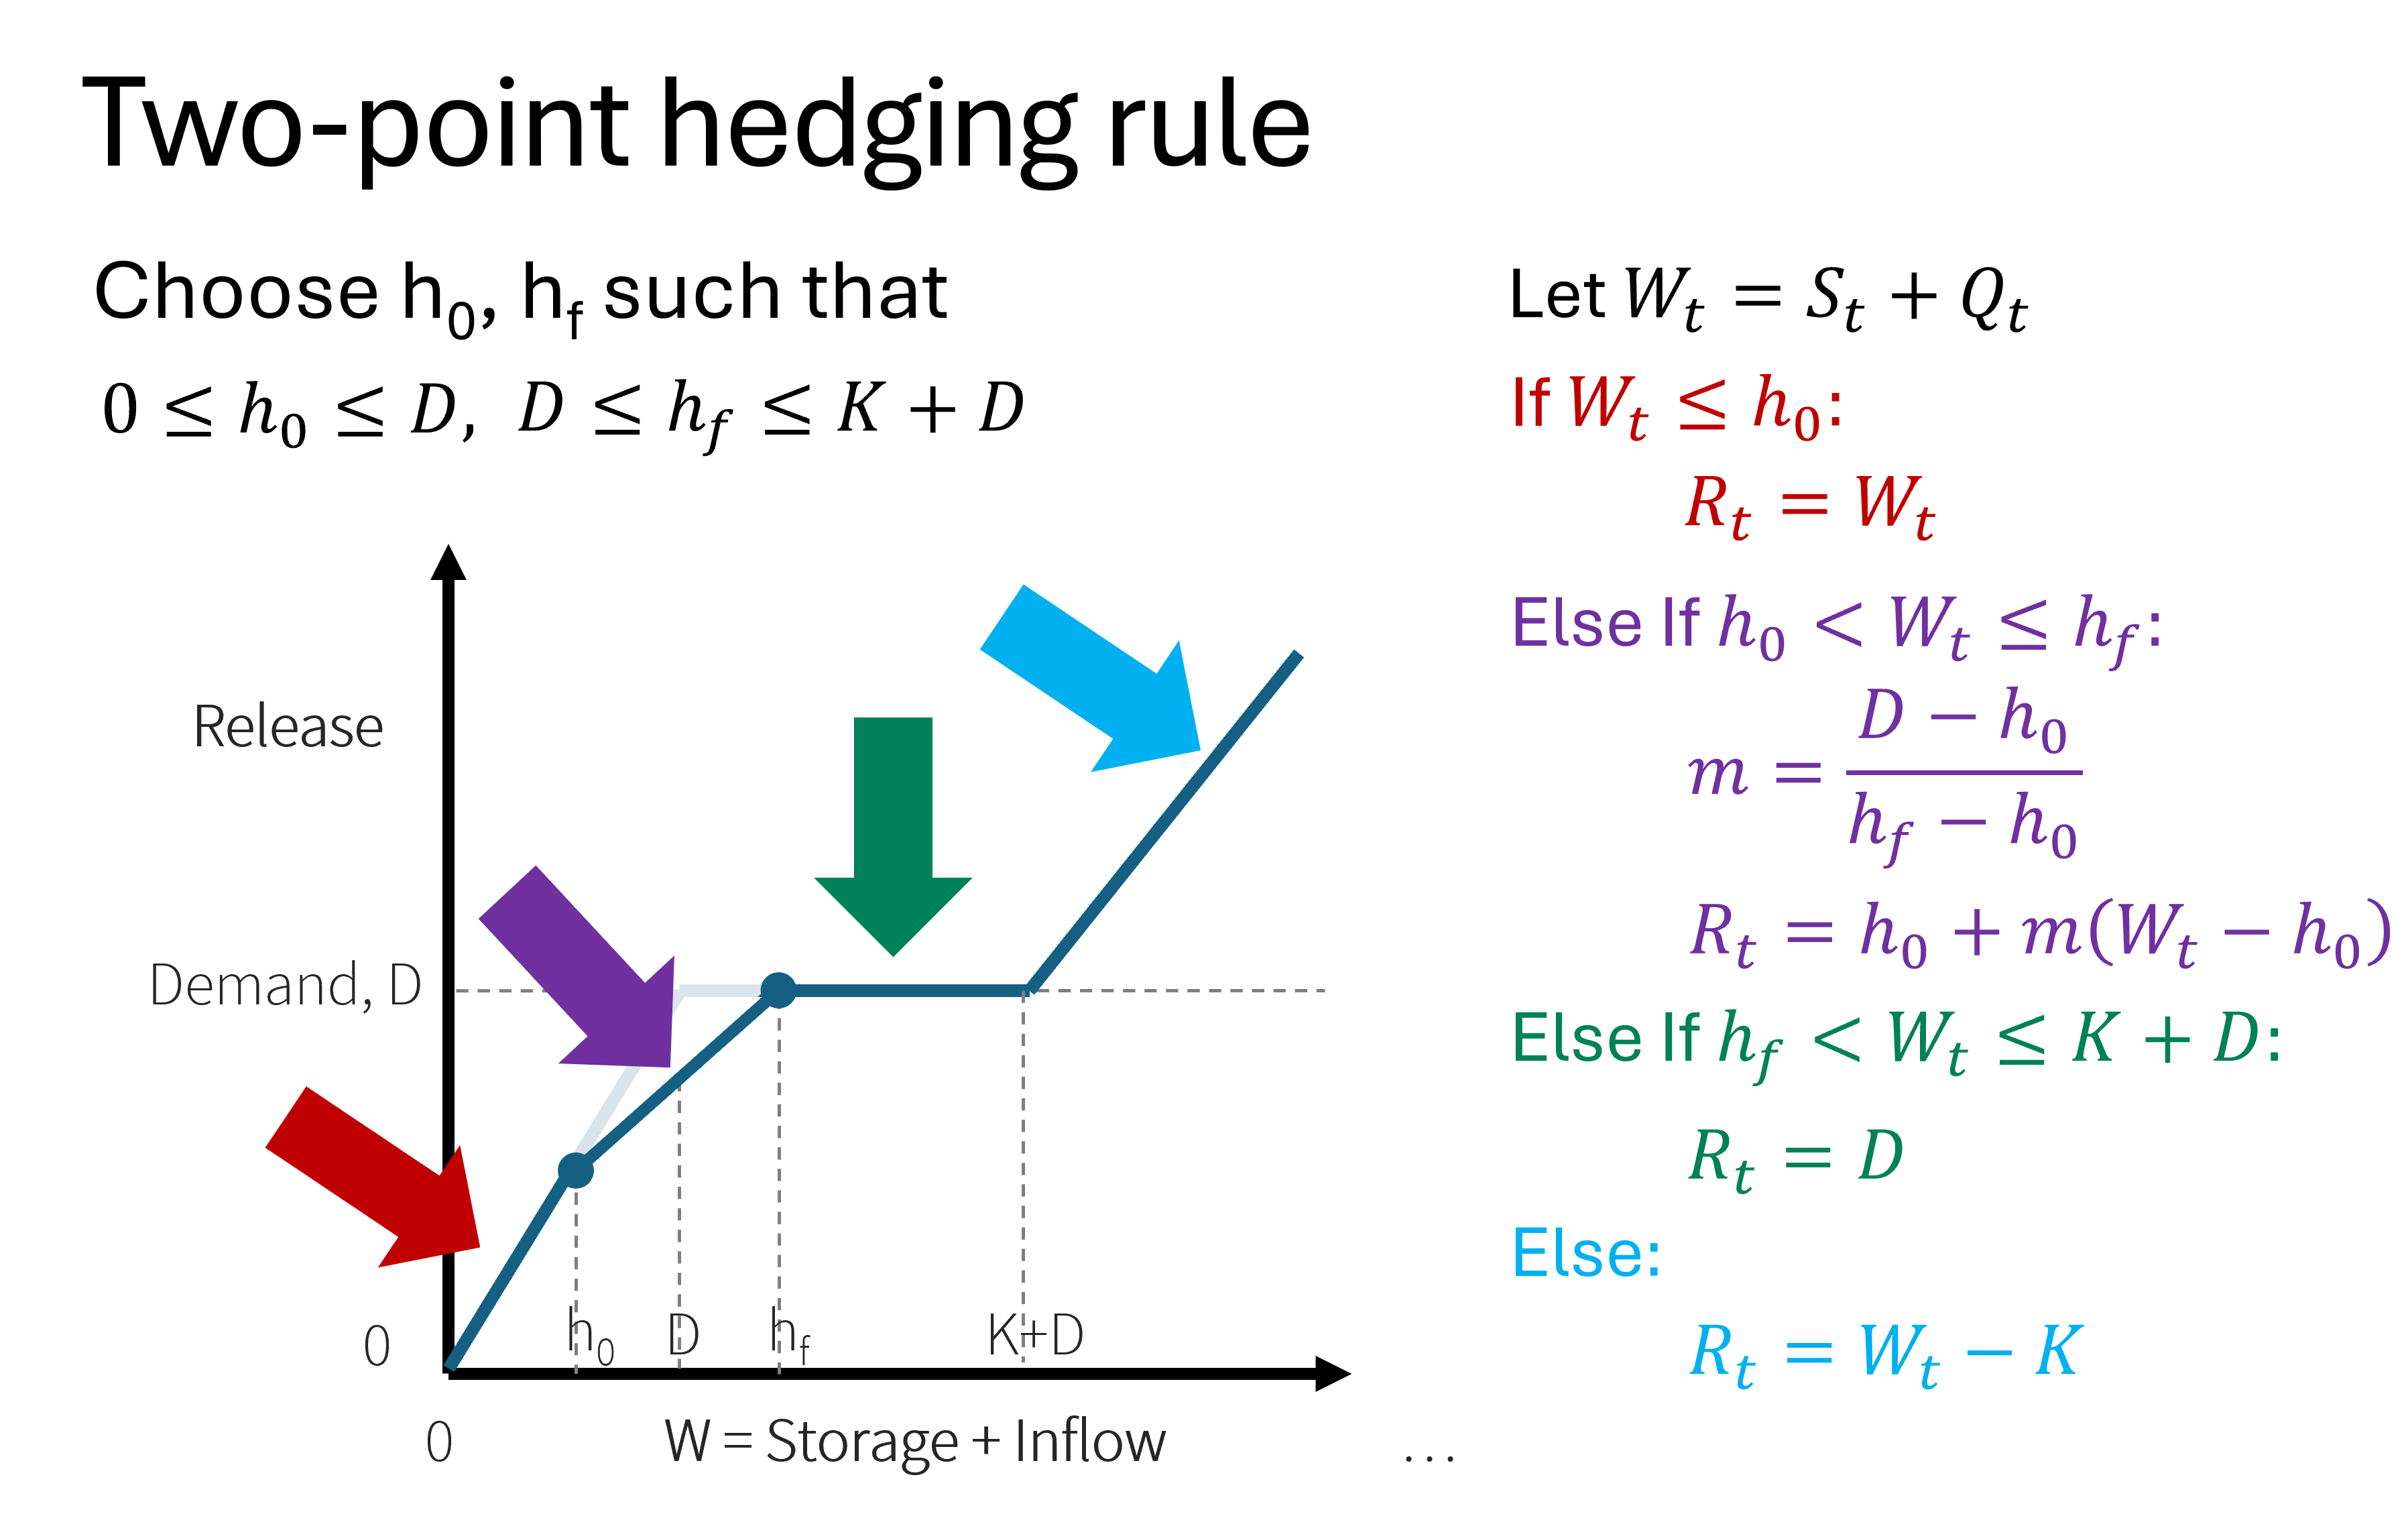

In [ ]:
K = 975 # capacity, TAF
D = 150 # target yield, TAF
a = 0.35
b = 2.3 # cost function parameters

nobjs = 2
nvars = 2

def simulate(vars, Q):
  # state variables
  T = len(Q)
  S = np.zeros(T)
  R = np.zeros(T)

  # operating policy parameters
  h0 = vars[0]
  hf = vars[1]

  # objectives
  cost = np.zeros(T)
  reliability = np.zeros(T)
  obs = [0.0]*nobjs

  S[0] = K # start simulation full
  for t in range(T):
    # determine R from hedging policy


    # calculate storage from mass balance
    if t < (T-1):
      S[t+1] = # fill in

    # calculate objectives at this time step (reliability and cost)

  # calculate average objective value across time steps
  objs[0] =
  objs[1] =

  return objs

## 3. Multi-Objective optimization with NSGA-II

$\color{red}{\text{Now use platypus to optimize the hedging policy rules for these two objectives over the synthetic inflow data. The code below is complete.}}$

In [ ]:
problem = Problem(nvars, nobjs)
problem.types[:] = [Real(0,D), Real(D,K+D)]
problem.function = functools.partial(simulate,Q=synQ)

algorithm = NSGAII(problem)
algorithm.run(1000)

$\color{red}{\text{Re-arrange the best solutions into arrays with the values of the decision variables and objectives. The code below is complete.}}$

In [ ]:
nsolns = len(unique(nondominated(algorithm.result)))
bestVars = np.zeros([nsolns,nvars])
bestObjs = np.zeros([nsolns,nobjs])
for i, solution in enumerate(unique(nondominated(algorithm.result))):
  bestVars[i,:] = solution.variables
  bestObjs[i,:] = solution.objectives

$\color{red}{\text{Use the code chunk below to make a 2-D scatter plot of the objective values of the solutions in the Pareto set.}}$

## 4. Validation over Historical Inflows

$\color{red}{\text{Copy the code from your } \texttt{simulate} \text{ function above into the } \texttt{resimulate} \text{ function below, which also returns the simulated releases and storage.}}$

In [ ]:
def resimulate(vars, Q):
  # state variables
  T = len(Q)
  S = np.zeros(T)
  R = np.zeros(T)

  # operating policy parameters
  h0 = vars[0]
  hf = vars[1]

  # objectives
  cost = np.zeros(T)
  reliability = np.zeros(T)
  obs = [0.0]*nobjs

  S[0] = K # start simulation full
  for t in range(T):
    # determine R from hedging policy


    # calculate storage from mass balance
    if t < (T-1):
      S[t+1] = # fill in

    # calculate objectives at this time step (reliability and cost)

  # calculate average objective value across time steps
  objs[0] =
  objs[1] =

  return objs, R, S

$\color{red}{\text{Use the } \texttt{resimulate} \text{ function to re-simulate all the Pareto optimal policies over the historical streamflows using the code below, which is complete.}}$

In [ ]:
objs_hist = np.zeros([nsolns,nobjs])
R_hist = np.zeros([nsolns,len(histQ)])
S_hist = np.zeros([nsolns,len(histQ)])
for i, solution in enumerate(unique(nondominated(algorithm.result))):
  objs_hist[i,:], R_hist[i,:], S_hist[i,:] = resimulate(solution.variables,histQ)

$\color{red}{\text{Use the code chunk below to make a 2-D scatter plot of the objective values of the solutions in the Pareto set over}}$  
$\color{red}{\text{a) the synthetic streamflows and b) the historical streamflows using two different colors.}}$

## 5. Comparison of hedging rules from operating policies favoring different objectives

$\color{red}{\text{Use the code below to find the policy that does best on each objective over the historical record, and which is closest to the ideal point after normalizing the objectives.}}$

In [ ]:
lowestShortage = np.argmin(objs_hist[:,0])
highestReliability = np.argmin(objs_hist[:,1])
distIdeal = ((objs_hist[:,0]-np.min(objs_hist[:,0]))/np.min(objs_hist[:,0]))**2 + \
 ((objs_hist[:,1]-np.min(objs_hist[:,1]))/np.min(objs_hist[:,1]))**2
bestCompromise = np.argmin(distIdeal)

### a. Plot hedging rules from selected policies

$\color{red}{\text{Edit the } \texttt{getpolicy} \text{ function below to find the release prescribed by different policies based on their hedging rule parameters } \texttt{vars} \text{ and the amount of available water, } W.}$

In [ ]:
def getPolicy(W, vars):
  h0 = vars[0]
  hf = vars[1]
  R = np.zeros(len(W))
  for i in range(len(W)):
    # find R[i] based on W[i], h0 and hf

  return R

W = np.linspace(0,np.max(histQ),100)
R_lowestShortage = getPolicy(W,bestVars[lowestShortage,:])
R_highestReliability = getPolicy(W,bestVars[highestReliability,:])
R_bestCompromise = getPolicy(W,bestVars[bestCompromise,:])

$\color{red}{\text{Use the code chunk below to plot the hedging rule for the three selected policies in a different color for each: lowestShortage, lowestAlteration, and bestCompromise.}}$

## b. Plot time series of selected policies on actual historical data

$\color{red}{\text{Use the code chunk below to make a two-panel plot of the storages and releases simulated by the selected policies,}}$  
$\color{red}{\text{with the storages in one plot and releases in another, and a different color for each policy.}}$

In [ ]:
S_lowestShortage = S_hist[lowestShortage,:]
S_highestReliability = S_hist[highestReliability,:]
S_bestCompromise = S_hist[bestCompromise,:]

R_lowestShortage = R_hist[lowestShortage,:]
R_highestReliability = R_hist[highestReliability,:]
R_bestCompromise = R_hist[bestCompromise,:]

# plot above time series on two-panel plot, with a different color line for each policy
